In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
sns.set_theme()
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("colorblind")

In [3]:
pd.options.display.float_format = "{:.5f}".format

In [4]:
SEED = 0

## Data Prep

In [5]:
df_train = pd.read_csv("../data/training_data.csv")
df_val   = pd.read_csv("../data/validation_data.csv")
df_test  = pd.read_csv("../data/testing_data_dirty.csv")

preprocessor = joblib.load("../models/pipeline.joblib")

In [6]:
df_X_train = df_train.drop(columns=["price_raw", "price_log"])
df_y_train = df_train[["price_raw", "price_log"]]

df_X_val   = df_val.drop(columns=["price_raw", "price_log"])
df_y_val   = df_val[["price_raw", "price_log"]]

df_X_test_orig = df_test.drop(columns=["price_raw"])
df_X_test = preprocessor.transform(df_test)
df_y_test  = df_test[["price_raw"]]
df_y_test["price_log"] = np.log1p(df_test["price_raw"])

/tmp/ipykernel_13715/2740495345.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y_test["price_log"] = np.log1p(df_test["price_raw"])


In [7]:
X_train = df_X_train.values
X_val   = df_X_val.values
X_test  = df_X_test.values

y_train = df_y_train["price_log"].values
y_val   = df_y_val["price_log"].values
y_test  = df_y_test["price_log"].values

y_train_raw = df_y_train["price_raw"].values
y_val_raw  = df_y_val["price_raw"].values
y_test_raw = df_y_test["price_raw"].values

In [8]:
X_train_val = np.concat((X_train, X_val))
y_train_val = np.concat((y_train, y_val))
y_train_val_raw = np.concat((y_train_raw, y_val_raw))

## Errors

In [9]:
def get_errors(true_log, pred_log, fold=None):
    true = np.expm1(true_log)
    pred = np.expm1(pred_log)
    result = pd.Series({
        "r2": r2_score(true_log, pred_log),
        "mse": mean_squared_error(true, pred),
        "rmse": root_mean_squared_error(true, pred),
        "mae": mean_absolute_error(true, pred),
        "mape": mean_absolute_percentage_error(true, pred),
    })
    if fold is not None:
        result["fold"] = fold
    return result

In [10]:
def get_errors_final(y_train, y_train_pred, y_test, y_test_pred):
    s_train = get_errors(y_train, y_train_pred)
    s_test  = get_errors(y_test, y_test_pred)
    df_errors = pd.DataFrame((s_train, s_test))
    df_errors.index = ["train and validation", "test"]
    return df_errors.T

## Cross Validation

In [11]:
kf = KFold(10, shuffle=True, random_state=SEED)

In [12]:
def cross_validate(model, X_train_val, y_train_val):
    errors_all = []
    for fold, (idx_train, idx_val) in enumerate(kf.split(X_train_val, y_train_val), start=1):
        X_t, X_v = X_train_val[idx_train], X_train_val[idx_val]
        y_t, y_v = y_train_val[idx_train], y_train_val[idx_val]
        model.fit(X_t, y_t)
        y_v_pred = model.predict(X_v)
        errors = get_errors(y_v, y_v_pred, fold=fold)
        errors_all.append(errors)
    df_errors = pd.DataFrame(errors_all)
    df_errors["fold"] = df_errors["fold"].astype("int")
    df_errors = df_errors.set_index("fold")
    df_errors.loc["mean"] = df_errors.mean()
    return df_errors

## Linear Regression

### Model

In [13]:
lr = LinearRegression()

In [14]:
cross_validate(lr, X_train_val, y_train_val)

,r2,mse,rmse,mae,mape
fold,,,,,
1,0.71813,538378155870.55530,733742.56785,340429.51237,0.38104
2,0.71838,734455642872.78979,857003.87565,383904.12343,0.39333
3,0.72775,401145773258.68604,633360.69760,309137.59752,0.35387
4,0.72224,432764647314.05731,657848.49875,333964.94220,0.38998
5,0.72171,377603940810.28149,614494.86638,319875.12953,0.39076
6,0.71155,489844165444.36438,699888.68075,332926.13179,0.36908
7,0.74134,497387038209.21899,705256.71795,346270.28896,0.37382
8,0.70478,490808071936.08441,700576.95647,341533.89176,0.38962
9,0.73874,528569530017.89362,727027.87431,354993.36693,0.36518


In [15]:
lr.fit(X_train_val, y_train_val)

y_train_val_pred_lr = lr.predict(X_train_val)
y_test_pred_lr = lr.predict(X_test)

In [16]:
get_errors_final(y_train_val, y_train_val_pred_lr, y_test, y_test_pred_lr)

,train and validation,test
r2,0.72110,0.70991
mse,497010844570.80023,491081282472.10455
rmse,704989.96062,700771.91901
mae,342318.95263,343375.14662
mape,0.38099,0.38502


In [17]:
joblib.dump(lr, "../models/lr.joblib")

['../models/lr.joblib']

### Error Analysis

In [18]:
alpha = 0.05

In [19]:
residuals = y_train_val - y_train_val_pred_lr

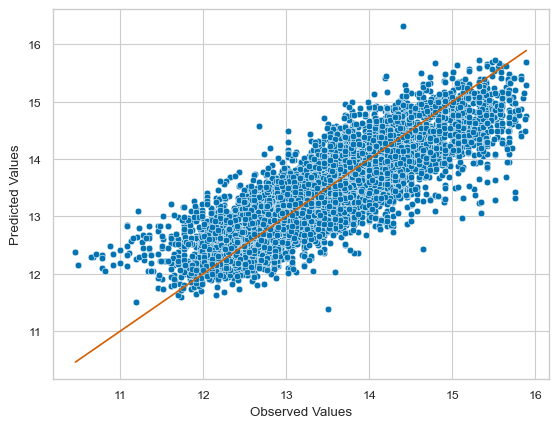

In [20]:
# linearity
sns.scatterplot(x=y_train_val, y=y_train_val_pred_lr)
sns.lineplot(x=[y_train_val.min(), y_train_val.max()], y=[y_train_val.min(), y_train_val.max()], color=sns.color_palette()[3])
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.savefig("../plots/linearity.pdf")

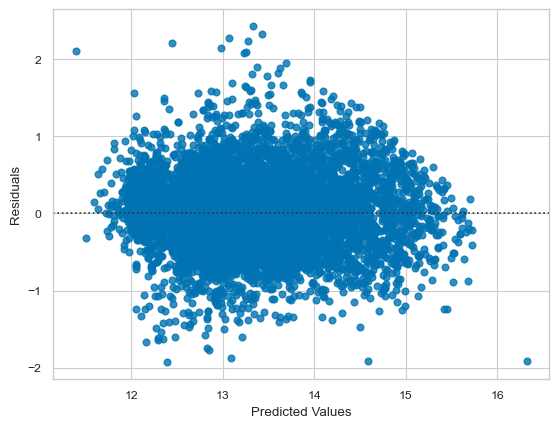

In [21]:
# homoscedasticity
sns.residplot(x=y_train_val_pred_lr, y=residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig("../plots/homoscedasticity.pdf")

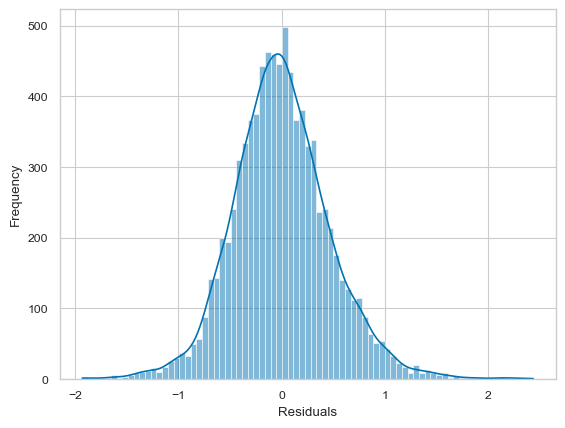

In [22]:
# normality of residuals
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.savefig("../plots/normality.pdf")

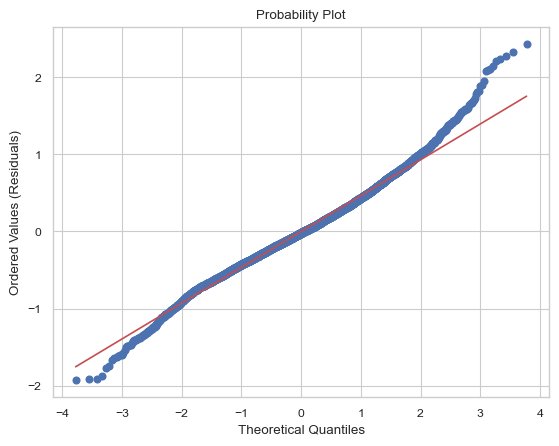

In [23]:
stats.probplot(residuals, plot=plt)
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Ordered Values (Residuals)")
plt.savefig("../plots/qq.pdf")

In [24]:
X_train_sm = sm.add_constant(pd.concat((df_X_train, df_X_val)))
ols_model = sm.OLS(y_train_val, X_train_sm).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     1496.
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        16:20:48   Log-Likelihood:                -5723.7
No. Observations:                8694   AIC:                         1.148e+04
Df Residuals:                    8678   BIC:                         1.159e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          10.9088      0.030    364.409      0.000      10.850      10.967
bathrooms                       2.1693      0.080     27.090      0.000       2.012       2.326
indoor_surface                  2.7543      0.070     39.166      0.000       2.616       2.892
communal_pool                   0.0241      0.019      1.304      0.192      -0.012       0.060
u/f_heating_climate_control     0.2474      0.020     12.450      0.000       0.208       0.286
gym                             0.1804      0.016     10.985      0.000       0.148       0.213
communal_garden                -0.0193      0.018     -1.101      0.271      -0.054       0.015
domotics                        0.1190      0.026      4.639      0.000       0.069       0.169
private_pool                    0.2694      0.019     14.205      0.000       0.232       0.307
private_garden                 -0.0320      0.015     -2.098      0.036      -0.062      -0.002
barbeque                       -0.0355      0.015     -2.428      0.015      -0.064      -0.007
jacuzzi                         0.0194      0.019      1.011      0.312      -0.018       0.057
luxury                          0.2765      0.013     21.050      0.000       0.251       0.302
bedrooms                       -0.8402      0.121     -6.967      0.000      -1.077      -0.604
alarm_system_security           0.0618      0.014      4.333      0.000       0.034       0.090
games_room                     -0.1474      0.025     -5.947      0.000      -0.196      -0.099
==============================================================================
Omnibus:                      317.567   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              610.205
Skew:                           0.276   Prob(JB):                    3.13e-133
Kurtosis:                       4.175   Cond. No.                         39.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
df_p = pd.DataFrame({
    "Coefficient": ols_model.params,
    "p-Value": ols_model.pvalues,
    f"Significant (p < {alpha})": ols_model.pvalues < alpha
})
df_p.sort_values(by="p-Value")

,Coefficient,p-Value,Significant (p < 0.05)
const,10.90880,0.00000,True
indoor_surface,2.75431,0.00000,True
bathrooms,2.16933,0.00000,True
luxury,0.27651,0.00000,True
private_pool,0.26937,0.00000,True
u/f_heating_climate_control,0.24743,0.00000,True
gym,0.18044,0.00000,True
bedrooms,-0.84021,0.00000,True
games_room,-0.14740,0.00000,True
domotics,0.11904,0.00000,True


## XGBoost

In [26]:
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    min_child_weight=5,
    reg_alpha=0,
    reg_lambda=1,
    n_jobs=-1,
    random_state=SEED
)

In [27]:
cross_validate(xgb, X_train_val, y_train_val)

,r2,mse,rmse,mae,mape
fold,,,,,
1,0.73938,482397500318.13837,694548.41467,328742.33129,0.36529
2,0.74149,524333687069.09412,724108.89172,361773.17556,0.37589
3,0.73891,393285351159.01813,627124.66955,304610.44163,0.34247
4,0.74247,395989609754.77612,629277.05326,324403.29921,0.36890
5,0.73269,365854428917.27570,604859.01574,312225.29801,0.37578
6,0.72170,470395532923.34290,685853.87141,331719.85375,0.36166
7,0.75694,480391560419.67542,693102.84981,333422.86668,0.35834
8,0.71609,481539988843.68475,693930.82425,342823.52075,0.37885
9,0.75349,457761289422.81366,676580.58605,337700.71548,0.35274


In [28]:
xgb.fit(X_train_val, y_train_val)

y_train_val_pred_xgb = xgb.predict(X_train_val)
y_test_pred_xgb = xgb.predict(X_test)

In [29]:
get_errors_final(y_train_val, y_train_val_pred_xgb, y_test, y_test_pred_xgb)

,train and validation,test
r2,0.77214,0.72302
mse,363734664403.72052,431017387909.47980
rmse,603104.19034,656519.14512
mae,301476.72585,328606.54797
mape,0.33921,0.37053


In [30]:
joblib.dump(xgb, "../models/xgb.joblib")

['../models/xgb.joblib']

## MLP

In [31]:
nn = MLPRegressor(
    hidden_layer_sizes=[128, 64, 32],
    batch_size=64,
    activation="relu",
    alpha=0.001,
    learning_rate_init=0.0001,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=20,
    solver="adam",
    random_state=SEED,
)

In [32]:
# cross_validate(nn, X_train_val, y_train_val)

In [33]:
nn.fit(X_train, y_train);

In [34]:
y_train_pred_nn = nn.predict(X_train)
y_val_pred_nn = nn.predict(X_val)

In [35]:
get_errors(y_train, y_train_pred_nn)

r2                0.74813
mse    423133156795.80896
rmse         650486.86136
mae          319753.13440
mape              0.36444
dtype: float64

In [36]:
get_errors(y_val, y_val_pred_nn)

r2                0.73245
mse    614725919423.77112
rmse         784044.59020
mae          347838.14941
mape              0.37205
dtype: float64

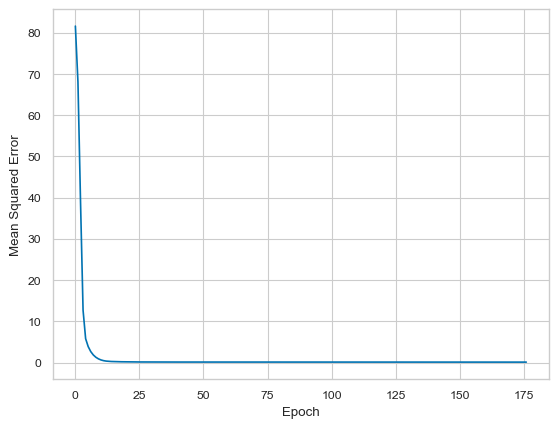

In [37]:
sns.lineplot(nn.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.savefig("../plots/epochs.pdf")

In [38]:
nn.fit(X_train_val, y_train_val)

y_train_val_pred_nn = nn.predict(X_train_val)
y_test_pred_nn = nn.predict(X_test)

In [39]:
get_errors_final(y_train_val, y_train_val_pred_nn, y_test, y_test_pred_nn)

,train and validation,test
r2,0.74445,0.70765
mse,450014981460.07465,499297164791.45160
rmse,670831.55968,706609.62687
mae,324021.37662,344508.09598
mape,0.34936,0.37041


In [40]:
joblib.dump(nn, "../models/nn.joblib")

['../models/nn.joblib']